In [1]:
import sys

# adding Folder_2 to the system path
#sys.path.insert(0, '/Users/lisadang/Desktop/Github/SPCA')

import astro_models
import numpy as np
import matplotlib.pyplot as plt
import pickle, os
import batman
import emcee
import astropy
from astropy.time import Time
import h5py
import corner
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from multiprocessing import Pool
import matplotlib.ticker as mticker
from mc3.stats import time_avg
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy.visualization import quantity_support

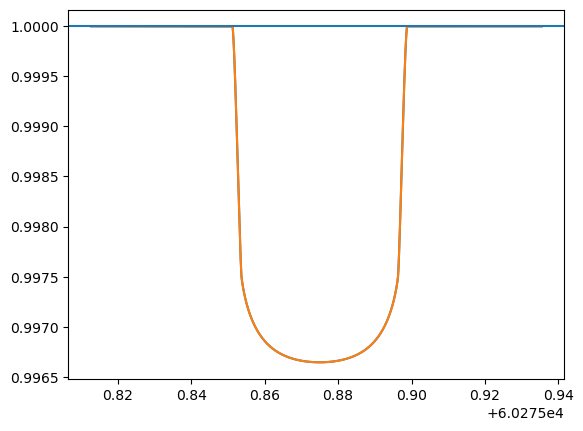

In [3]:
# LHS1140c parameters
# params.per = 3.777940                 #orbital period
# params.rp = 0.05486                   #planet radius (in units of stellar radii)
# params.a = 26.57                        #semi-major axis (in units of stellar radii)
# params.inc = 89.8                    #orbital inclination (in degrees)
# params.ecc = 0.                       #eccentricity
# params.w = 90.                        #longitude of periastron (in degrees)
# params.limb_dark = "nonlinear"        #limb darkening model
# params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]
# params.fp = 0.000230                  #planet to star flux ratio
# params.t_secondary = eclipse.to_value(format='mjd')
t0 = 60275.875
per = 3.777940
rp = 0.05486
a = 26.57
inc = 89.8
ecc = 0
w = 90
ecosw, esinw = 0,0
q1, q2 = 0.2, 0.2 #0.00001, 0.000001
u1, u2 = 0.2, 0.2
fp = 0.000230
A, B = 0.5, 0.000001

time=np.linspace(60275.81270206, 60275.93550997, 1000000)
flux=astro_models.ideal_lightcurve(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2,
                                   fp, A, B, C=0, D=0, r2=None, r2off=None)
A, B = 0.5-0.00001, 0.00001
flux2=astro_models.ideal_lightcurve(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2,
                                   fp, A, B, C=0, D=0, r2=None, r2off=None)
plt.plot(time, flux)
plt.plot(time, flux2)
plt.axhline(y=1)
flux = astro_models.transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2)
#plt.plot(time, flux[0])

In [83]:
# load decorrelated data

path1 = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse1/LHS1140c-S3_ap4_bg12_30/S3_lhs1140c_ap4_bg12_30_FluxData_seg0000.h5'

with h5py.File(path1, 'r') as file:     # open the file
    print("Keys: %s" % file.keys())
    a_group_key = list(file.keys())[0]
    time0 = np.array(file['time'])
    aplev0 = np.array(file['aplev'])
    aperr0 = np.array(file['aperr'])
    # bglev0 = np.array(file['bglev'])
    # bgerr0 = np.array(file['bgerr'])
    centroid_x0 = np.array(file['centroid_x'])
    centroid_y0 = np.array(file['centroid_y'])
    centroid_sx0 = np.array(file['centroid_sx'])
    centroid_sy0 = np.array(file['centroid_sy'])
    flux0 = np.array(file['flux'])
    x0 = np.array(file['x'])
    y0 = np.array(file['y'])

path2 = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse1/LHS1140c-S3_ap7_bg12_30/S3_lhs1140c_ap7_bg12_30_FluxData_seg0001.h5'
with h5py.File(path2, 'r') as file:     # open the file
    time1 = np.array(file['time'])
    aplev1 = np.array(file['aplev'])
    aperr1 = np.array(file['aperr'])
    centroid_x1 = np.array(file['centroid_x'])
    centroid_y1 = np.array(file['centroid_y'])

path3 = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse1/LHS1140c-S3_ap7_bg12_30/S3_lhs1140c_ap7_bg12_30_FluxData_seg0002.h5'
with h5py.File(path3, 'r') as file:     # open the file
    time2 = np.array(file['time'])
    aplev2 = np.array(file['aplev'])
    aperr2 = np.array(file['aperr'])
    centroid_x2 = np.array(file['centroid_x'])
    centroid_y2 = np.array(file['centroid_y'])

path4 = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse1/LHS1140c-S3_ap7_bg12_30/S3_lhs1140c_ap7_bg12_30_FluxData_seg0003.h5'
with h5py.File(path4, 'r') as file:     # open the file
    time3 = np.array(file['time'])
    aplev3 = np.array(file['aplev'])
    aperr3 = np.array(file['aperr'])
    centroid_x3 = np.array(file['centroid_x'])
    centroid_y3 = np.array(file['centroid_y'])

path5 = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse1/LHS1140c-S3_ap7_bg12_30/S3_lhs1140c_ap7_bg12_30_FluxData_seg0004.h5'
with h5py.File(path5, 'r') as file:     # open the file
    time4 = np.array(file['time'])
    aplev4 = np.array(file['aplev'])
    aperr4 = np.array(file['aperr'])
    centroid_x4 = np.array(file['centroid_x'])
    centroid_y4 = np.array(file['centroid_y'])

# # path2 = '/Users/lisadang/Desktop/LHS1140_spitzer/LHS1140-2/analysis/ch2/addedBlank/ignore/4umPLD_3x3/\
# # PLDAper1_3x3_v1_first_nocheckphase/Bestfit_PLDAper1_3x3_v1_first_nocheckphase.pkl'


# with open(path5, "rb") as input_file:
#     LHS1140_5 = pickle.load(input_file)

Keys: <KeysViewHDF5 ['aperr', 'aplev', 'betaper', 'centroid_sx', 'centroid_sy', 'centroid_x', 'centroid_y', 'dq', 'err', 'flux', 'mask', 'nappix', 'nskyideal', 'nskypix', 'skyerr', 'skylev', 'status', 'time', 'v0', 'wave_1d', 'x', 'y']>


In [192]:
aperture = ['4']
#aperture = ['4', '7', '12']
segments = ['0000', '0001', '0002', '0003', '0004']

# Initialize dictionaries to hold arrays for each aperture
time = {a: [] for a in aperture}
aplev = {a: [] for a in aperture}
aperr = {a: [] for a in aperture}
centroid_x = {a: [] for a in aperture}
centroid_y = {a: [] for a in aperture}

for a in aperture:
    for seg in segments:
        path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse1/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        with h5py.File(path, 'r') as file:     # open the file
            time[a] = np.append(time[a], np.array(file['time']))
            aplev[a] = np.append(aplev[a], np.array(file['aplev']))
            aperr[a] = np.append(aperr[a], np.array(file['aperr']))
            centroid_x[a] = np.append(centroid_x[a], np.array(file['centroid_x']))
            centroid_y[a] = np.append(centroid_y[a], np.array(file['centroid_y']))

    time[a] = np.array(time[a])
    aplev[a] = np.array(aplev[a])
    aperr[a] = np.array(aperr[a])
    centroid_x[a] = np.array(centroid_x[a])
    centroid_y[a] = np.array(centroid_y[a])
    
print(time['4'])

[60275.77646891 60275.77659717 60275.77672543 ... 60275.93794689
 60275.93807515 60275.93820341]


In [92]:
time = np.concatenate((time0,time1, time2, time3, time4), axis = 0)
aplev = np.concatenate((aplev0, aplev1, aplev2, aplev3, aplev4), axis = 0)
aperr = np.concatenate((aperr0, aperr1, aperr2, aperr3, aperr4), axis = 0)
centroid_x = np.concatenate((centroid_x0, centroid_x1, centroid_x2, centroid_x3, centroid_x4), axis = 0)
centroid_y = np.concatenate((centroid_y0, centroid_y1, centroid_y2, centroid_y3, centroid_y4), axis = 0)
# remove first few points
n = 200
time, aplev, aperr, centroid_x, centroid_y = time[n:], aplev[n:], aperr[n:], centroid_x[n:], centroid_y[n:]

Text(0.5, 1.0, 'Raw Flux Data')

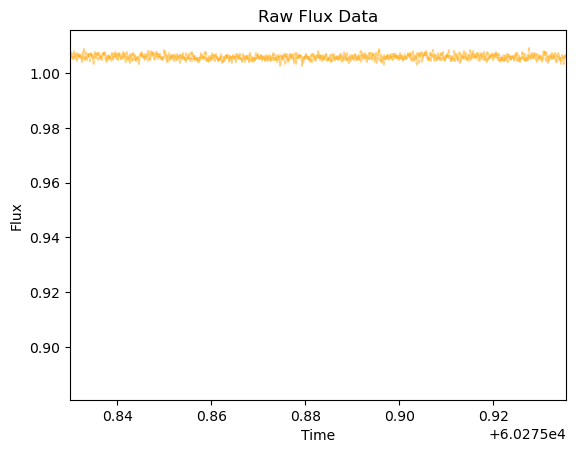

In [94]:
# plot flux & uncertainties
aperr = aperr / np.mean(aplev)
aplev = aplev / np.mean(aplev)

plt.figure()
plt.errorbar(time, aplev, yerr=aperr, alpha=0.3, color='orange')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(60275.83, 60275.93550997)
plt.title('Raw Flux Data')


In [ ]:
# plot flux & uncertainties
time = time['4'][200:]
aplev = aplev['4'][200:]
aperr = aperr['4'][200:]
centroid_x = centroid_x['4'][200:]
centroid_y = centroid_y['4'][200:]

In [193]:
time = time['4']
aplev = aplev['4']
aperr = aperr['4']
centroid_x = centroid_x['4']
centroid_y = centroid_y['4']

aperr = aperr / np.mean(aplev)
aplev = aplev / np.mean(aplev)

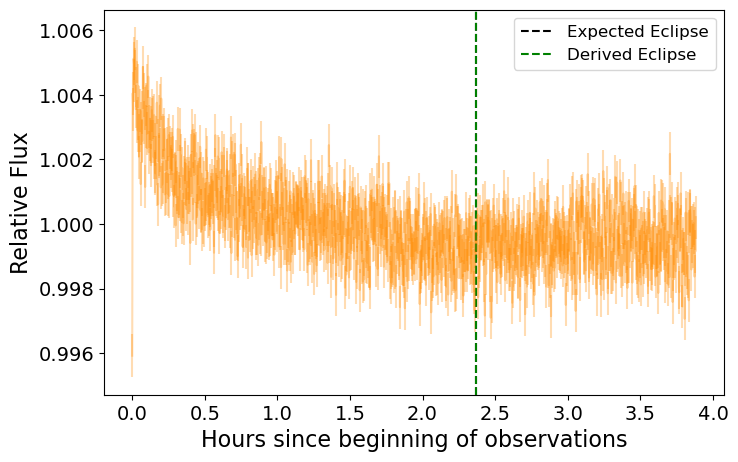

In [194]:
eclipse = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
eclipse = eclipse.mjd
derived = 60275.875009902804
plt.figure(figsize=(8,5))
plt.errorbar((time-time[0])*(24), aplev, yerr=aperr, alpha=0.3, color='darkorange')
plt.axvline(x=(eclipse-time[0])*(24), color='k', linestyle='--', label='Expected Eclipse')
plt.axvline(x=(derived-time[0])*(24), color='g', linestyle='--', label='Derived Eclipse')
plt.xlabel('Hours since beginning of observations', fontsize=16)
plt.ylabel('Relative Flux', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=12)
plt.savefig('LHS1140_c.pdf')

In [191]:
np.abs(derived-eclipse) / 3.950276004616171e-05

0.25068637877499117

### Fit 4th Transit (poly)

In [6]:
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=False):
    """Bin values and compute their binned noise.

    Args:
        values (ndarray): An array of values to bin.
        binAxisValues (ndarray): Values of the axis along which binning will occur.
        nbin (int): The number of bins desired.
        assumeWhiteNoise (bool, optional): Divide binned noise by sqrt(nbinned) (True) or not (False, default).

    Returns:
        tuple: binned (ndarray; the binned values),
            binnedErr (ndarray; the binned errors)
    
    """
    
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

In [288]:
nbin = 25
aperr     = aperr/np.mean(aplev)
aplev     = aplev/np.mean(aplev)
# if doing this here need to shift t_o and t_s -> causes issues
# timezero = time.min()
# time     = time-timezero

# remove more points to get the ramp out...
bins_t, binErr_t = binValues(time[200:], time[200:], nbin)
bins_aplev, binErr_aplev = binValues(aplev[200:], time[200:], nbin)
bins_aperr, binErr_aperr = binValues(aperr[200:], time[200:], nbin)
bins_centroid_x, binErr_centroid_x = binValues(centroid_x[200:], time[200:], nbin)
bins_centroid_y, binErr_centroid_y = binValues(centroid_y[200:], time[200:], nbin)


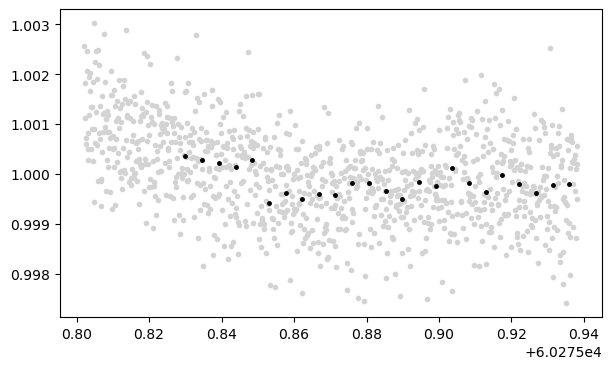

In [26]:
plt.figure(figsize = [7,4])
plt.plot(time, aplev, color = 'lightgrey', marker = '.', linestyle = 'None')
plt.plot(bins_t, bins_aplev, '.k', markersize = 5)
#plt.ylim(0.997,1.003)

In [123]:
# initialize parameters
t_0 = 58388.7939
per = 3.777940
rp = 0.05486
a = 26.57
inc = 89.8
ecc = 0
w = 90
fp = 0.000230
t_s = 60275.875


In [9]:
def detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6):
    """Model the detector systematics with a 2D polynomial model based on the centroid.
    Args:
        detec_inputs (tuple): (x, y, mode) with dtypes (ndarray, ndarray, string). Formatted this
            way to allow for easy minimization with scipy.optimize.minimize.
        c1--c21 (float): The polynomial model amplitudes.
    Returns:
        ndarray: The flux variations due to the detector systematics.
    """

    x, y = xdata, ydata
    pos = np.vstack((np.ones_like(x),
                     x   ,      y,
                     x**2, x   *y,      y**2))
    detec = np.array([c1, c2, c3, c4, c5, c6])
    return np.dot(detec[np.newaxis,:], pos).reshape(-1)

def signal(time, xdata, ydata, t_s, fp, c1, c2, c3, c4, c5, c6):

    astro = transit_model(time, t_s, fp)
    detec = detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6)

    return astro*detec
#def signal(time, xdata, ydata, t_0, t_s, rp, a, inc, fp, u1, u2, c1, c2, c3, c4, c5, c6):

In [28]:
def transit_model(time, t_s, fp):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 58388.7939                #time of inferior conjunction
    params.per = 3.777940                 #orbital period
    params.rp = 0.05486                   #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux

# plus tard fix t0, t_s -> let e free (and w) 
# def transit_model(time, t_0, t_s, rp, a, inc, fp, u1, u2): 

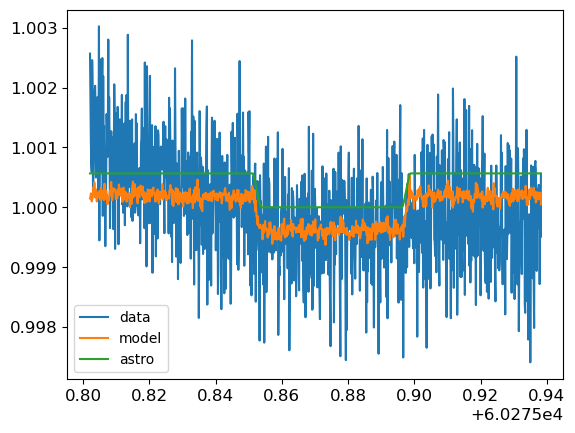

In [289]:
p0_astro = np.array([t_s, fp]) #t0, t_s, rp, a, inc, u1, u2, c1, c2, c3, c4, c5, c6
p0_detec = np.array([0.5, 0.1, 0.1, -0.1, 0.1, 0.1])

# p0 = np.concatenate((p0_astro, p0_detec))
# guess = signal(bins_t, bins_centroid_x, bins_centroid_y, *p0)
# guessa = transit_model(bins_t, *p0_astro)

# plt.plot(bins_t, bins_aplev, label = 'data')

# plt.plot(bins_t, guess/np.mean(guess), label = 'model')
# plt.plot(bins_t, guessa, label = 'astro')
#plt.plot(bins_t, bins_aplev-((guess/np.mean(guess))), label = 'residuals')
# plt.legend()

#full data
p0 = np.concatenate((p0_astro, p0_detec))
guess = signal(time, centroid_x, centroid_y, *p0)
guessa = transit_model(time, *p0_astro)
plt.plot(time, aplev, label = 'data')
plt.plot(time, guess/np.mean(guess), label = 'model')
plt.plot(time, guessa, label = 'astro')
plt.legend()

In [13]:
# TESTS
# def transit_model(time, t_0, t_s, rp, a, inc, fp, u1, u2, u3, u4):
#     params = batman.TransitParams()       #object to store transit parameters
#     params.t0 = t_0                     #time of inferior conjunction
#     params.per = 3.777940                 #orbital period
#     params.rp = rp                   #planet radius (in units of stellar radii)
#     params.a = a                        #semi-major axis (in units of stellar radii)
#     params.inc = inc                    #orbital inclination (in degrees)
#     params.ecc = 0.                       #eccentricity
#     params.w = 90.                        #longitude of periastron (in degrees)
#     params.limb_dark = "nonlinear"        #limb darkening model
#     params.u = [u1, u2, u3, u4]      #limb darkening coefficients [u1, u2, u3, u4]
#     params.fp = fp                  #planet to star flux ratio
#     params.t_secondary = t_s

#     m = batman.TransitModel(params, time, transittype="secondary")
#     flux = m.light_curve(params)
#     return flux

# # params = transit_model(t_0, t_s, rp, a, inc, fp, u1, u2, u3, u4)
# # m = batman.TransitModel(params, time, transittype="secondary")    #initializes model

# flux = transit_model(bins_t, t_0, t_s, rp, a, inc, fp, u1, u2, u3, u4)
# plt.plot(bins_t, flux)
# plt.plot(bins_t, bins_aplev, 'o')
# # plt.ylim(0.997, 1.003)

# def transit_model(time, t_0, t_s, rp, a, inc, fp, u1, u2):
#     params = batman.TransitParams()       #object to store transit parameters
#     params.t0 = t_0                     #time of inferior conjunction
#     params.per = 3.777940                 #orbital period
#     params.rp = rp                   #planet radius (in units of stellar radii)
#     params.a = a                        #semi-major axis (in units of stellar radii)
#     params.inc = inc                    #orbital inclination (in degrees)
#     params.ecc = 0.                       #eccentricity
#     params.w = 90.                        #longitude of periastron (in degrees)
#     params.limb_dark = "quadratic"        #limb darkening model
#     params.u = [u1, u2]      #limb darkening coefficients [u1, u2, u3, u4]
#     params.fp = fp                  #planet to star flux ratio
#     params.t_secondary = t_s

#     m = batman.TransitModel(params, time, transittype="secondary")
#     flux = m.light_curve(params)
#     return flux

# # params = transit_model(t_0, t_s, rp, a, inc, fp, u1, u2, u3, u4)
# # m = batman.TransitModel(params, time, transittype="secondary")    #initializes model

# flux = transit_model(bins_t, t_0, t_s, rp, a, inc, fp, u1, u2)
# plt.plot(bins_t, flux)
# plt.plot(bins_t, bins_aplev, 'o')
# plt.ylim(0.997, 1.003)

### Defining likelihood function

In [30]:
def log_likelihood(theta, time, flux, xdata, ydata):
    t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta

    model = signal(time, xdata, ydata, t_s, fp, c1, c2, c3, c4, c5, c6)
    sigma2 = sigF**2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

# def log_prior(theta):
#     t_0, t_s, rp, a, inc, fp, u1, u2, c1, c2, c3, c4, c5, c6, sigF = theta

#     # gaussian prior
#     prior  = 0.
#     prior -= 0.5*(((rp - 0.054860358472478575)/0.0008)**2.)
#     prior -= 0.5*(((t_0 - 58388.7939)/0.000040)**2.)

#     if (58388. < t_0 < 58388. and 60275.8 < t_s <60275.95 and 0.04<rp<0.06 and 26.5 < a < 26.6 
#         and inc < 90 and 0.001 < fp < 0.004  and sigF > 0. and 0.<u1<0.3 and 0.<u2<0.3):
#         return 0.0 + prior
#     return np.inf

def log_prior(theta):
    t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta

    # gaussian prior
    prior = 0.
    prior -= 0.5 * (((t_s - 60275.875) / 0.000040) ** 2.)

    # uniform prior
    if (0 < fp < 1 and sigF > 0.): 
        return 0.0 + prior
    return np.inf

def log_prob(theta, time, flux, xdata, ydata):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, xdata, ydata)

#t_0, t_s, rp, a, inc, fp, u1, u2, c1, c2, c3, c4, c5, c6, sigF = theta
#prior -= 0.5 * (((t_0 - 58388.7939) / 0.000040) ** 2.)
#58388.7939 * 0.95 < t_0 < 58388.7939 * 1.05 and 
#60275.875 * 0.95 < t_s < 60275.875 * 1.05 and 
#0.05486 * 0.95 < rp < 0.05486 * 1.05 and 
#26.57 * 0.95 < a < 26.57 * 1.05 and 
#0 < inc < 90 and 

### MCMC

In [140]:
p0 = np.concatenate((p0_astro, p0_detec, [0.001]))
nsteps, nwalkers, ndim = 10000, 50, len(p0)

# lower the initial position scatter
pos = p0 + 1e-5 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time, aplev, centroid_x, centroid_y))
pos2, prob, state = sampler.run_mcmc(pos, nsteps, progress=True)

#pos3, prob, state = sampler.run_mcmc(pos2, nsteps, progress=True)


100%|██████████| 10000/10000 [01:10<00:00, 141.37it/s]


In [39]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time, aplev, centroid_x, centroid_y), pool=pool)
    pos2, prob, state = sampler.run_mcmc(pos2, nsteps, progress=True)

### Saving MCMC Run

In [141]:
nBurnInSteps2 = 1000
lnprobchain = sampler.get_log_prob(discard=nBurnInSteps2).swapaxes(0,1)
chain = sampler.get_chain(discard=nBurnInSteps2).swapaxes(0,1)

savepath = 'MCMC_results/'
#Saving MCMC Results
pathchain = savepath + 'samplerchain_10000.npy'
pathlnlchain = savepath + 'samplerlnlchain_10000.npy'
pathposit = savepath + 'samplerposi_10000.npy'
pathlnpro = savepath + 'samplerlnpr_10000.npy'
np.save(pathchain, chain)
np.save(pathlnlchain, lnprobchain)
np.save(pathposit, pos2)
np.save(pathlnpro, prob)

In [225]:
samples = chain.reshape((-1, ndim))

MCMC_Results = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))

maxk, maxiter = np.unravel_index((lnprobchain).argmax(), (lnprobchain).shape)
p0_mcmc = chain[maxk, maxiter,:]
for i in range(len(p0_mcmc)):
    MCMC_Results[i] = (p0_mcmc[i], MCMC_Results[i][1], MCMC_Results[i][2])

p0_labels = ['t_s','fp', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'sigF']

out = "MCMC result:\n\n"
for i in range(len(p0_mcmc)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])
print(out, flush=True)


MCMC result:

     t_s = 60275.875009902804  +3.950276004616171e-05  -3.9974656829144806e-05
      fp = 0.0005661522322664744  +5.785961593619154e-05  -5.756880696813492e-05
     c_1 = 17730.416599415825  +108612.55927736592  -100067.32002473425
     c_2 = -577.3964182724981  +1054.3949354097622  -1123.927909842413
     c_3 = 299.19505252170916  +744.2669008025866  -747.3005481276974
     c_4 = 3.3211362314861095  +3.2486184249070345  -3.1475749619459314
     c_5 = -2.095418597080444  +3.770569313694578  -3.6953771219296794
     c_6 = -0.13441836110831995  +1.7021878626366225  -1.6723932426099455
    sigF = 0.0008645465418480156  +1.9510954200001166e-05  -1.848751295066781e-05



In [37]:
# load previous MCMC results
pathchain = 'MCMC_results/samplerchain_5000.npy'
pathlnlchain = 'MCMC_results/samplerlnlchain_5000.npy'
pathposit = 'MCMC_results/samplerposi_5000.npy'
pathlnpro = 'MCMC_results/samplerlnpr_5000.npy'
chain = np.load(pathchain)
lnprobchain = np.load(pathlnlchain)
pos2 = np.load(pathposit)
prob = np.load(pathlnpro)

#ndim = len(pos2[0])

(50, 9000)


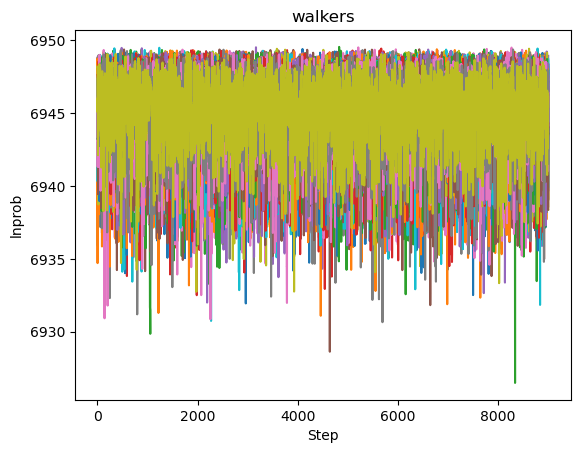

In [143]:
#plt.plot(lnprobchain)
print(lnprobchain.shape)
#new_lnprobchain = lnprobchain[::2, 50000:]
plt.figure()
for i in range(0, len(lnprobchain)-1):
    plt.plot(lnprobchain[i,:], '-')
# set x axis as log scale
#plt.yscale("log")
#plt.ylim(5000,# 10000)
plt.title('Walkers '+str(i))
plt.title('walkers')
plt.xlabel('Step')
plt.ylabel('lnprob')
plt.show()

In [41]:
print(samples.shape)
print(chain.shape)

(245000, 9)
(50, 4900, 9)


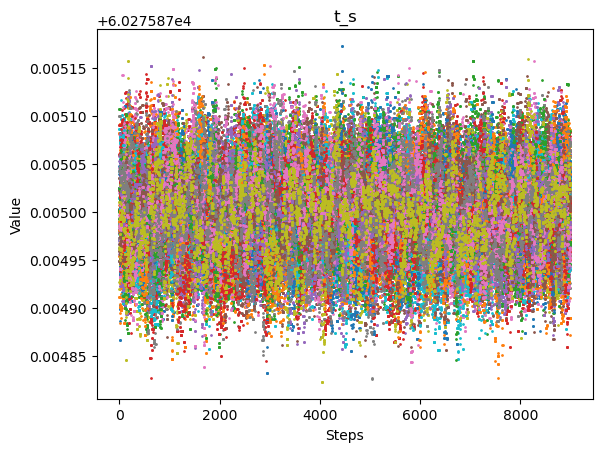

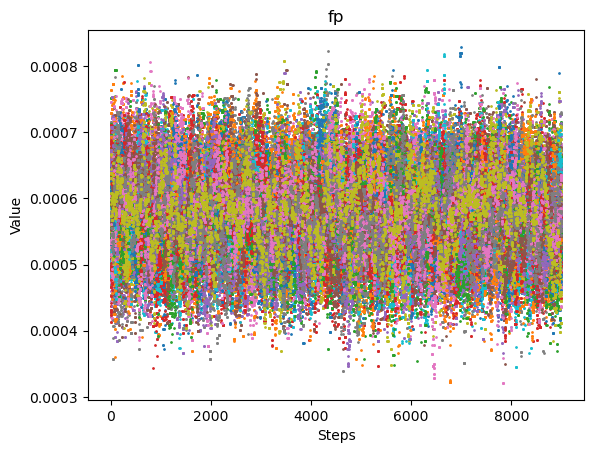

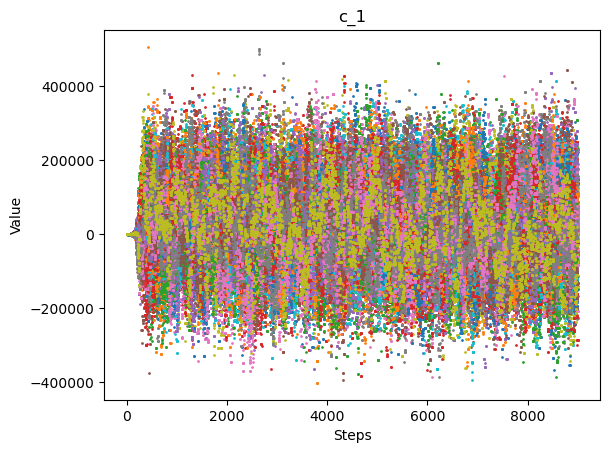

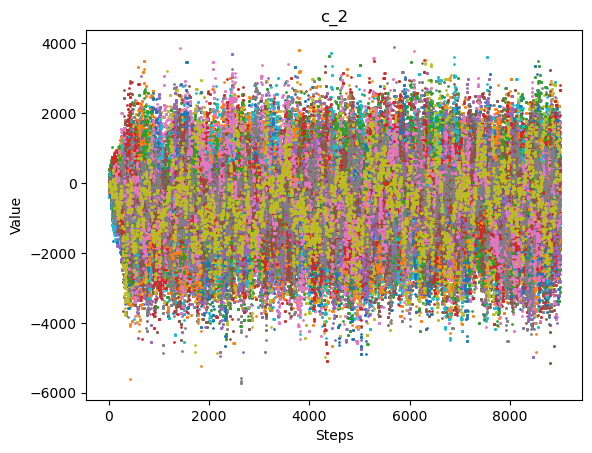

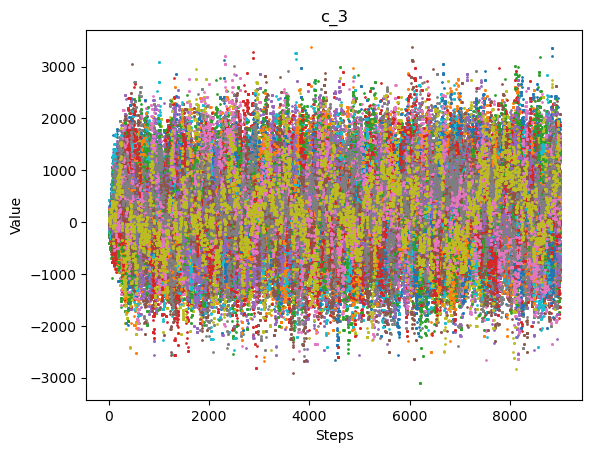

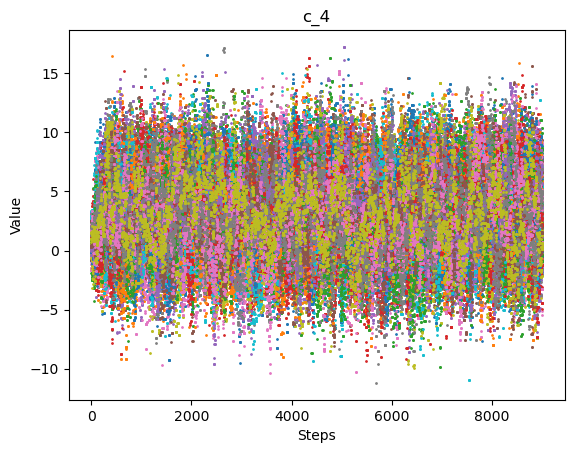

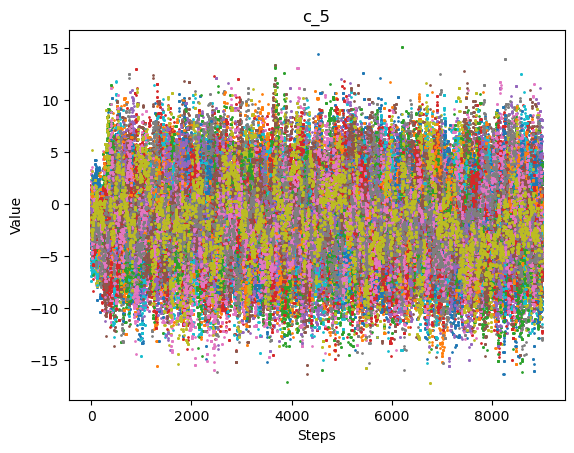

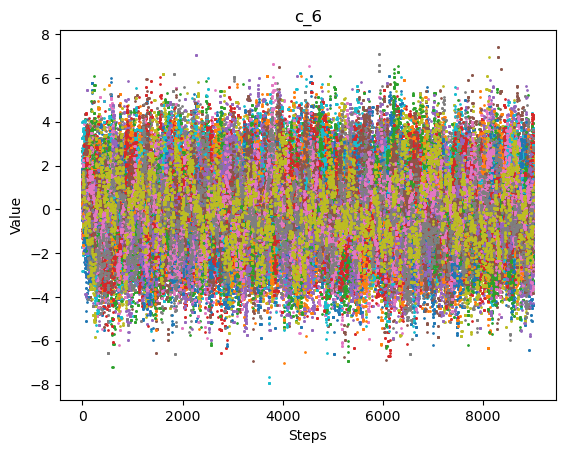

In [144]:
p0_labels = ['t_s', 'fp', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'sigF']

new_chain = chain#[::2,::10,:]
samples = new_chain.reshape((-1, ndim))

walker_labels = ['Walker '+str(i) for i in range(0, len(new_chain)-1)]
for i in range(0, len(p0_labels)-1):
    plt.figure()
    for j in range(0, len(new_chain)-1):
        plt.plot(new_chain[j,:,i], 'o', markersize=1, label=walker_labels[j])
    plt.title(p0_labels[i])
    plt.xlabel('Steps')
    plt.ylabel('Value')
    #plt.legend()
    plt.title(p0_labels[i])
    plt.xlabel('Steps')
    plt.ylabel('Value')

# for i in range(0, len(p0_labels)-1):

#     fig, ax = plt.subplots(1,2, figsize=(10,5))
#     for j in range(0, len(new_chain)-1):
#         ax[0].plot(new_chain[j,:,i], 'o')
#     ax[0].set_title(p0_labels[i])
#     ax[0].set_xlabel('Steps')
#     ax[0].set_ylabel('Value')

#     ax[1].plot(new_chain[:,:,i], '-')
#     ax[1].set_title(p0_labels[i])
#     ax[1].set_xlabel('Walkers')
#     ax[1].set_ylabel('Value')

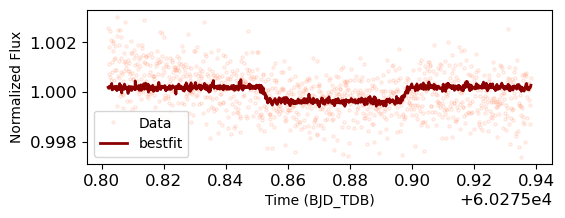

In [226]:
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
flux_bfit   = transit_model(time, t_s, fp)
signal_bfit = signal(time, centroid_x, centroid_y, t_s, fp, c1, c2, c3, c4, c5, c6)
detect_bfit = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)

plt.figure(figsize=(6,2))
plt.plot(time, aplev, 'o', fillstyle='none', markersize=2, alpha=0.2, color='coral', label='Data')
plt.plot(time, signal_bfit/np.mean(signal_bfit), label='bestfit', lw=2, color='darkred')
plt.xlabel('Time (BJD_TDB)')
plt.ylabel('Normalized Flux')
plt.legend()

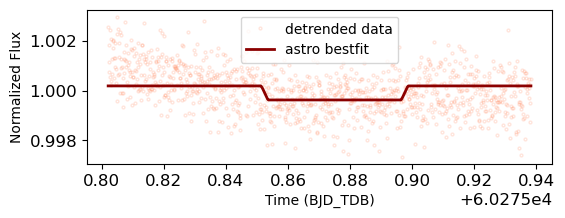

In [227]:
plt.figure(figsize=(6,2))
plt.plot(time, aplev/(detect_bfit/np.mean(detect_bfit)), 'o', fillstyle='none', markersize=2, alpha=0.2,
         color='coral', label='detrended data')
plt.plot(time, flux_bfit/np.mean(flux_bfit), label='astro bestfit', lw=2, color='darkred')
plt.xlabel('Time (BJD_TDB)')
plt.ylabel('Normalized Flux')
plt.legend()

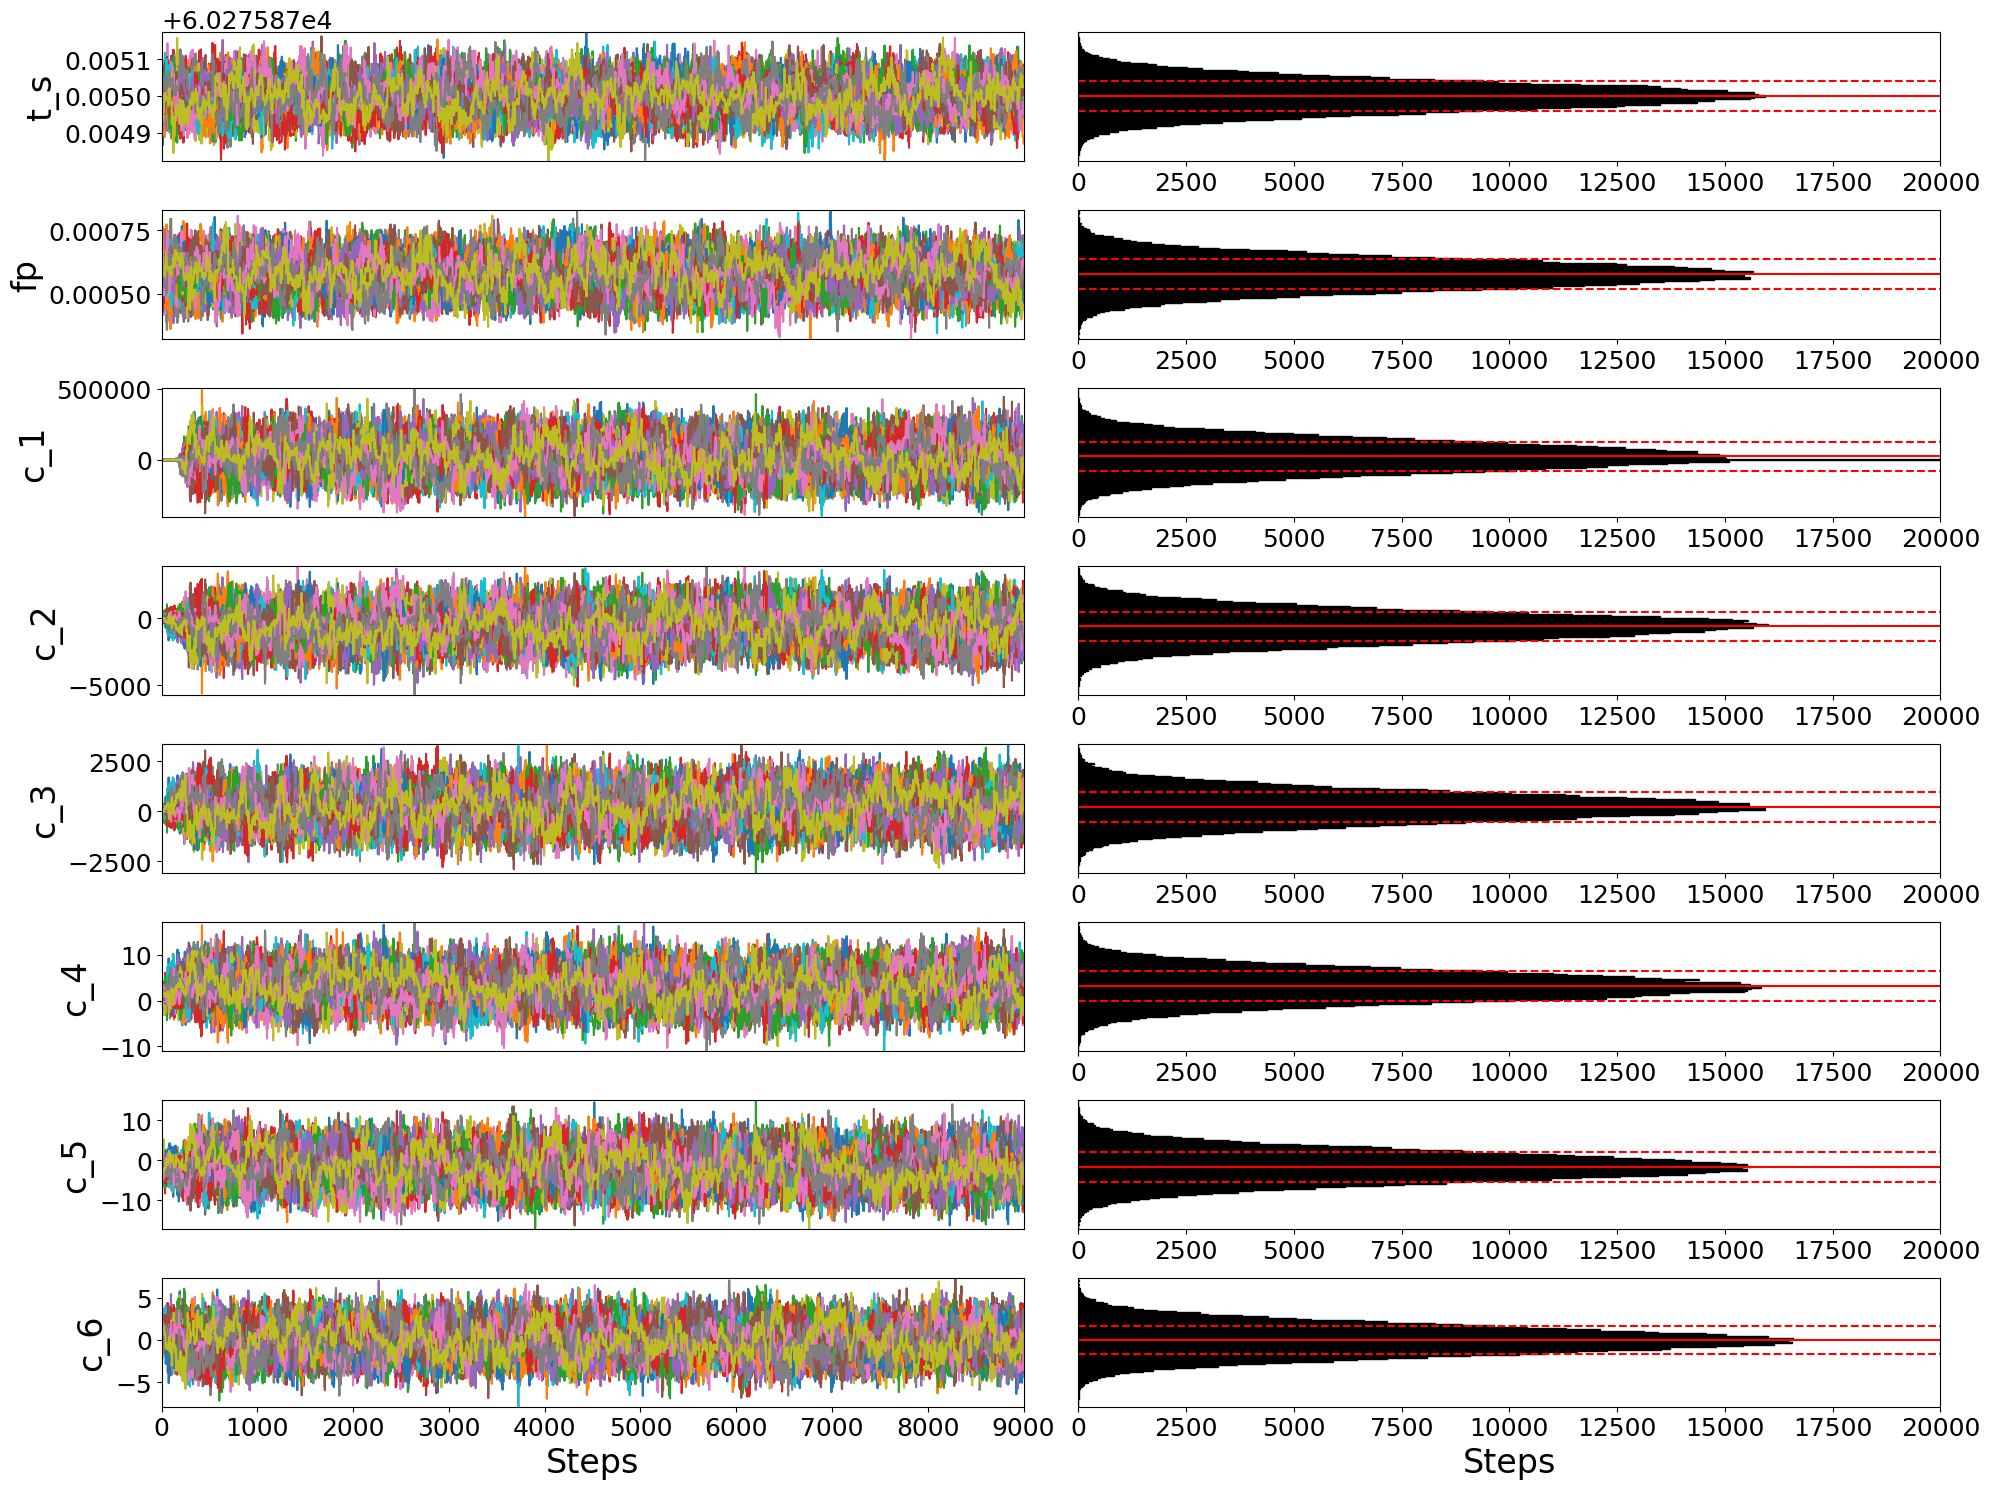

In [167]:
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

fig, ax = plt.subplots(len(new_chain.transpose())-1,2)

fig.set_figheight(15)
fig.set_figwidth(20)
fontsize = 24
#.set_ticks_params(labelsize=fontsize)

for i in range(0, len(new_chain.transpose())-1):
    for j in range(0, len(new_chain)-1):
        ax[i,0].plot(new_chain[j,:,i])
        #counts, bins, patches = ax[i,1].hist(chain[j,:,i], bins=100, histtype='step', alpha=0.7, color='k', orientation='horizontal')
    
    counts, bins, patches = ax[i,1].hist(samples[:,i], bins=100, histtype='step', alpha=1, color='k', facecolor='k', fill=True, orientation='horizontal')
    ax[i,1].set_xlim(0,20000)
    #ax[i,0].plot(chain[:,:,i])
    #ax[i,1].hist(samples[:,i], bins=100, histtype='step', color='k')
    ax[i,1].hlines(np.mean(chain[:,::2,i]), 0,20000, color='r')
    ax[i,1].hlines(np.mean(chain[:,::2,i])+np.std(chain[:,::2,i]), 0,20000, linestyle='--', color='r')
    ax[i,1].hlines(np.mean(chain[:,::2,i])-np.std(chain[:,::2,i]), 0,20000, linestyle='--', color='r')
    
    ax[i,0].set_ylim(np.min(chain[:,::2,i]), np.max(chain[:,:,i]))
    ax[i,1].set_ylim(np.min(chain[:,::2,i]), np.max(chain[:,:,i]))
    ax[i,0].set_xlim(0,chain.shape[1])
    ax[i,0].set_ylabel(p0_labels[i], fontsize = fontsize)
    ax[i,1].set_yticks([])


#plt.hist(samples, bins=50, color='black', density=True, alpha=0.7, orientation='horizontal')

# ax[0,0].set_ylim(np.min(chain[:,:,0]),np.max(chain[:,:,0]))
# ax[0,1].set_ylim(np.min(chain[:,:,0]),np.max(chain[:,:,0]))
ax[-1,0].set_xlabel('Steps', fontsize = fontsize)
ax[-1,1].set_xlabel('Steps', fontsize = fontsize)
for i in range(0, len(new_chain.transpose())-2):
    ax[i,0].set_xticks([])
fig.tight_layout()
fig.savefig('MCMC_results/MCMC_results_10000.png')

In [46]:
# plt.figure()
# for i in range(0, len(new_chain)-1):
#     plt.hist(chain[i,:,1], bins=100, histtype='step', alpha=0.7, color='k', orientation='horizontal', density=True)
# #plt.hist(chain[1,::2,0], bins=100, histtype='step', alpha=0.7, color='k', orientation='horizontal', density=True)
# plt.figure()
# plt.hist(samples[:,1], bins=100, histtype='step', color='k', orientation='horizontal')

In [47]:
def walk_style(chain, labels, interv=10, fname=None, showPlot=False, fontsize=15):
    """Make a plot showing the evolution of the walkers throughout the emcee sampling.
    Args:
        chain (ndarray): The ndarray accessed by calling sampler.chain when using emcee
        labels (ndarray): The fancy labels for each dimension
        interv (int): Take every 'interv' element to thin out the plot
        name (string, optional): The savepath for the plot (or None if you want to return the figure instead).
        showPlot (bool, optional): Whether or not you want to show the plotted figure.
    Returns:
        None

    """

    nwalk = chain.shape[0]
    ndim = chain.shape[-1]

    # get first index
    beg   = 0
    end   = len(chain[0,:,0])
    step  = np.arange(beg,end)
    step  = step[::interv]

    # number of columns and rows of subplots
    ncols = 4
    nrows = int(np.ceil(ndim/ncols))
    sizey = 2*nrows

    # plotting
    plt.figure(figsize = (15, 2*nrows))
    for ind in range(ndim):
        plt.subplot(nrows, ncols, ind+1)
        sig1 = (0.6827)/2.*100
        sig2 = (0.9545)/2.*100
        sig3 = (0.9973)/2.*100
        percentiles = [50-sig3, 50-sig2, 50-sig1, 50, 50+sig1, 50+sig2, 50+sig3]
        neg3sig, neg2sig, neg1sig, mu_param, pos1sig, pos2sig, pos3sig = np.percentile(chain[:,:,ind][:,beg:end:interv],
                                                                                       percentiles, axis=0)
        plt.plot(step, mu_param)
        plt.fill_between(step, pos3sig, neg3sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos2sig, neg2sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos1sig, neg1sig, facecolor='k', alpha = 0.1)
        plt.title(labels[ind], fontsize=fontsize)
        plt.xlim(np.min(step), np.max(step))
        if ind < (ndim - ncols):
            plt.xticks([])
        else:
            plt.xticks(rotation=25)

        y_formatter = ScalarFormatter(useOffset=False)
        plt.gca().yaxis.set_major_formatter(y_formatter)
        plt.gca().xaxis.set_tick_params(labelsize=fontsize*0.8)
        plt.gca().yaxis.set_tick_params(labelsize=fontsize*0.8)

    if fname != None:
        plt.savefig(fname, bbox_inches='tight')

    if showPlot:
        plt.show()

    #plt.close()
    return

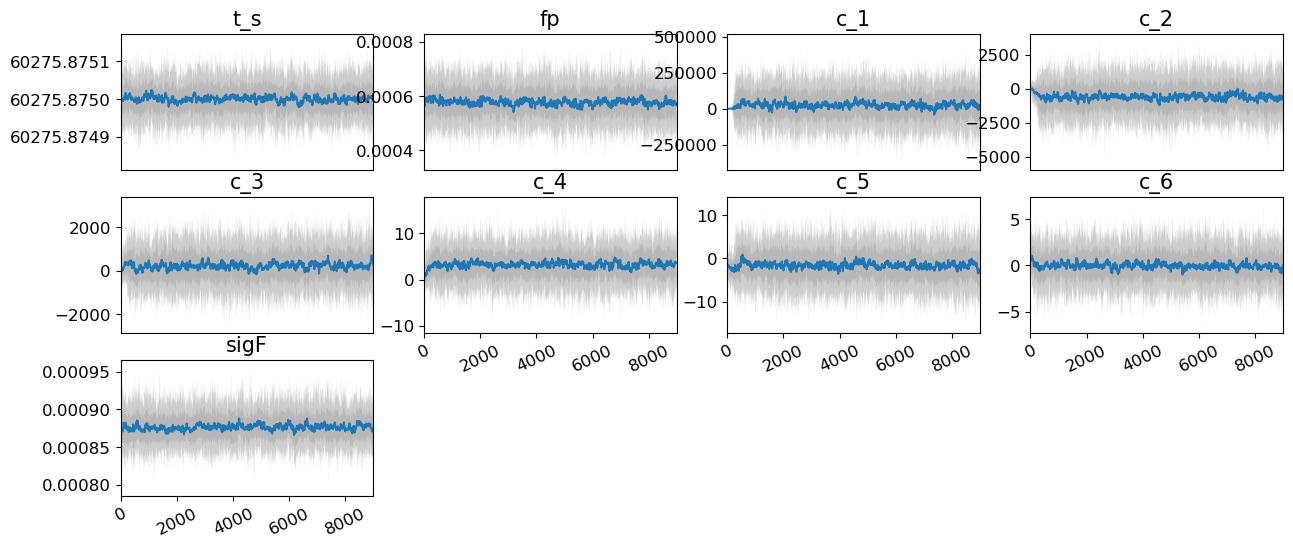

In [170]:
walk_style(chain, p0_labels, interv=10, fname='MCMC_results/walkers_10000.png', showPlot=True, fontsize=15)

In [174]:
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

labels = [r'$t_{s}$', r'$f_{p}$', r'$c_1$', r'$c_2$', r'$c_3$', r'$c_4$', r'$c_5$', r'$c_6$', r'$\sigma _F$']

samples = new_chain.reshape((-1, ndim))
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], labels = labels, show_titles=True,
                        plot_datapoints=False, label_kwargs={"fontsize": 24}, title_kwargs={"fontsize": 18}, quiet=False)

fig.savefig('MCMC_results/corner_10000.png')
plt.close()
# add save fig
                      

In [228]:
# BEST FIT 3 PANEL PLOT

def plot_bestfit(time, flux, astro, detec, showPlot=True, fontsize=24):
    
    x = time
    
    fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(8, 14))
    
    axes[0].set_xlim(np.nanmin(x), np.nanmax(x))
    axes[0].plot(x, flux, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[0].plot(x, astro*detec, '.', color = 'r', markersize = 2.5, alpha = 0.4)
    axes[0].set_ylabel('Raw Flux', fontsize=fontsize)

    axes[1].plot(x, flux/detec, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[1].plot(x, astro, color = 'r', linewidth=2)
    axes[1].set_ylabel('Calibrated Flux', fontsize=fontsize)
    
    axes[2].axhline(y=1, color='k', linewidth = 2, linestyle='dashed', alpha = 0.5)
    axes[2].plot(x, flux/detec, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[2].plot(x, astro, color = 'r', linewidth=2)

    axes[2].set_ylabel('Calibrated Flux', fontsize=fontsize)
    axes[2].set_ylim(ymin=1-3*np.nanstd(flux/detec - astro), ymax=np.max(astro)+3*np.nanstd(flux/detec - astro))

    axes[3].plot(x, flux/detec - astro, 'k.', markersize = 4, alpha = 0.15)
    axes[3].axhline(y=0, color='r', linewidth = 2)

    axes[3].set_ylabel('Residuals', fontsize=fontsize)
    axes[3].set_xlabel('Time (BMJD)', fontsize=fontsize)

    
    fig.align_ylabels()
    fig.subplots_adjust(hspace=0)
    fig.savefig('MCMC_results/best_fit_10000.png')
        
    if showPlot:
        plt.show()
    
    plt.close()
    return

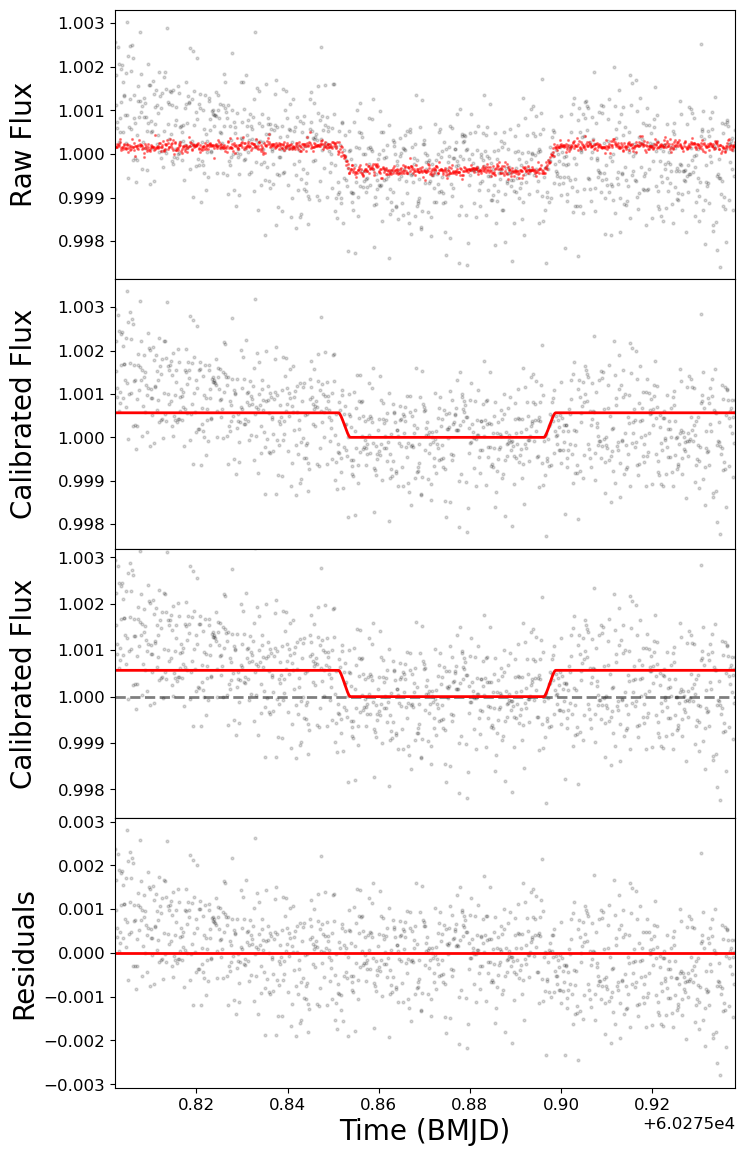

In [229]:
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
astro = transit_model(time, t_s, fp)
detec = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
plot_bestfit(time, aplev, astro, detec, showPlot=True, fontsize=20)

In [234]:
# MULTI LINE 3 PANEL PLOT

def plot_models(time, flux, p0, samples, nsamples=10, showPlot=True, fontsize=24, plotname='multifit'):
    
    x = time
    fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(8, 14))

    # best fit
    t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0
    best_astro = transit_model(time, t_s, fp)
    best_detec = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
    axes[0].set_xlim(np.nanmin(x), np.nanmax(x))
    axes[0].plot(x, flux, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[0].plot(x, best_astro*best_detec, '.', color = 'r', markersize = 2.5, alpha = 0.4)
    axes[0].set_ylabel('Raw Flux', fontsize=fontsize)

    axes[1].plot(x, flux/best_detec, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[1].plot(x, best_astro, color = 'r', linewidth=2)
    axes[1].set_ylabel('Calibrated Flux', fontsize=fontsize)
    
    axes[2].axhline(y=1, color='k', linewidth = 2, linestyle='dashed', alpha = 0.5)
    axes[2].plot(x, flux/best_detec, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[2].plot(x, best_astro, color = 'r', linewidth=2)

    axes[2].set_ylabel('Calibrated Flux', fontsize=fontsize)
    axes[2].set_ylim(0.9997, 1.0009)
    #axes[2].set_ylim(ymin=1-3*np.nanstd(flux/detec - astro), ymax=np.max(astro)+3*np.nanstd(flux/detec - astro))

    axes[3].plot(x, flux/best_detec - best_astro, 'k.', markersize = 4, alpha = 0.15)
    axes[3].axhline(y=0, color='r', linewidth = 2)

    axes[3].set_ylabel('Residuals', fontsize=fontsize)
    axes[3].set_xlabel('Time (BMJD)', fontsize=fontsize)

    p0 = np.array([np.random.choice(samples[:, i], size=nsamples, replace=False) for i in range(samples.shape[1])]).T
    for i in range(nsamples):

        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0[i,:]
        astro = transit_model(time, t_s, fp)
        detec = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
    
        axes[1].plot(x, astro, color = 'blue', linewidth=1, alpha = 0.3)
        axes[2].plot(x, astro, color = 'blue', linewidth=1, alpha = 0.3)
        
        # axes[3].plot(x, flux/detec - astro, 'k.', markersize = 4, alpha = 0.15)
    axes[1].plot(x, best_astro, color = 'r', linewidth=0.5)
    axes[2].plot(x, best_astro, color = 'r', linewidth=0.5)

    #axes[2].set_ylim(ymin=1-3*np.nanstd(flux/detec - astro), ymax=np.max(astro)+3*np.nanstd(flux/detec - astro))
    
    fig.align_ylabels()
    fig.subplots_adjust(hspace=0)
    fig.savefig('figs/'+plotname+'.png')
        
    if showPlot:
        plt.show()
    
    plt.close()
    return

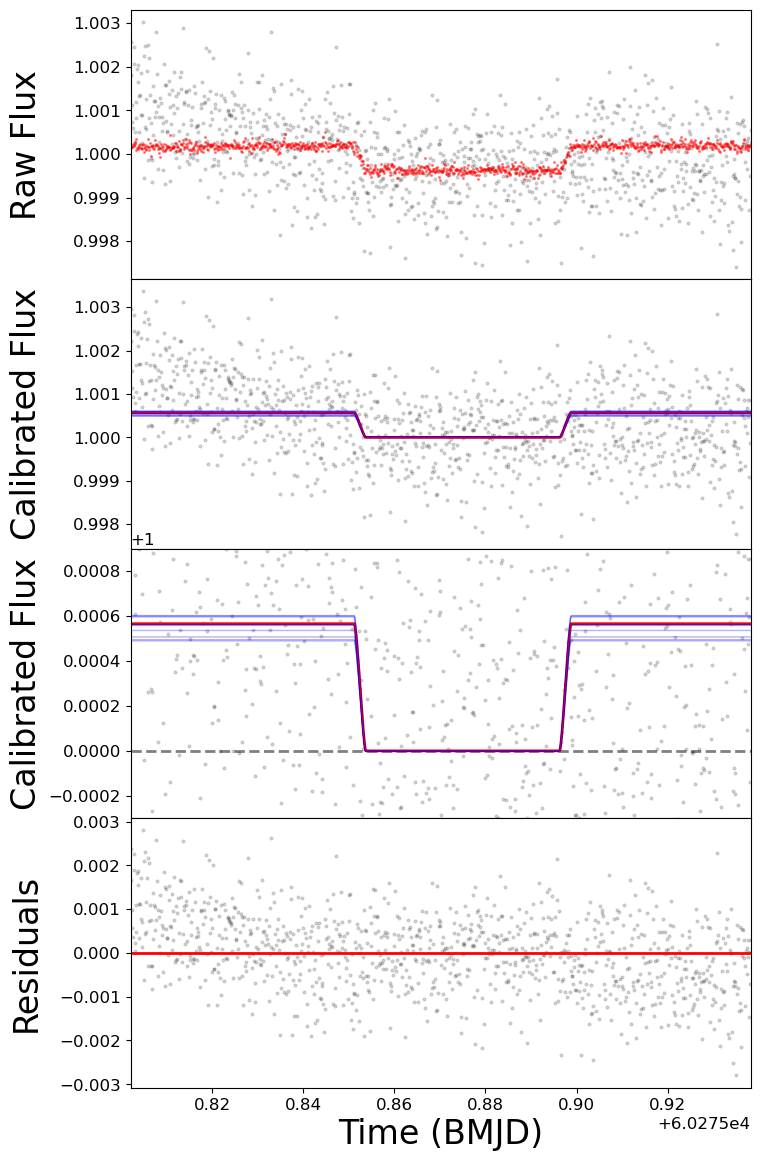

In [237]:
plot_models(time, aplev, p0_mcmc, samples, nsamples=10, plotname='multi_fit_n10_10000')

In [253]:
def plot_rednoise(residuals, minbins, occDuration = None, showPlot=True, fontsize=10):
    
    maxbins = int(np.rint(residuals.size/minbins))
    
    try:
        rms, rmslo, rmshi, stderr, binsz = time_avg(residuals, maxbins)
    except:
        rms = []
        for i in range(minbins,len(residuals)):
            rms.append(helpers.binnedNoise(np.arange(len(residuals)),residuals,i))
        rms = np.array(rms)[::-1]

        binsz = len(residuals)/np.arange(minbins,len(residuals))[::-1]

        #In case there is a NaN or something while binning
        binsz = binsz[np.isfinite(rms)]
        rms = rms[np.isfinite(rms)]
        rmslo = np.zeros_like(rms)
        rmshi = rmslo
        stderr = np.std(residuals)/np.sqrt(binsz)
    
    plt.clf()
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.errorbar(binsz, rms, yerr=[rmslo, rmshi], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS")
    ax.plot(binsz, stderr, c='red', label="Gaussian std.")
    ylim = ax.get_ylim()
    # ax.plot([ingrDuration,ingrDuration],ylim, color='black', ls='--', alpha=0.6)
    if occDuration is not None:
        ax.plot([occDuration,occDuration],ylim, color='black', ls='-.', alpha=0.6)
    ax.set_ylim(ylim)
    
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    
    plt.xlabel(r'N$_{\rm binned}$', fontsize=fontsize)
    plt.ylabel('RMS', fontsize=fontsize)
    plt.legend(loc='best', fontsize=fontsize)
    plt.savefig('figs/MCMC_RedNoise.png')

    if showPlot:
        plt.show()
    
    plt.close()
    
    # #Ingress Duration
    # sreal = rms[np.where(binsz<=ingrDuration)[0][-1]]*1e6
    # s0 = stderr[np.where(binsz<=ingrDuration)[0][-1]]*1e6
    # outStr = 'Over Ingress ('+str(round(ingrDuration*intTime*24*60, 1))+' min):\n'
    # outStr += 'Expected Noise (ppm)\t'+'Observed Noise (ppm)\n'
    # outStr += str(s0)+'\t'+str(sreal)+'\n'
    # outStr += 'Observed/Expected\n'
    # outStr += str(sreal/s0)+'\n\n'
    # #Occultation Duration
    # sreal = rms[np.where(binsz<=occDuration)[0][-1]]*1e6
    # s0 = stderr[np.where(binsz<=occDuration)[0][-1]]*1e6
    # outStr += 'Over Transit/Eclipse ('+str(round(occDuration*intTime*24*60, 1))+' min):\n'
    # outStr += 'Expected Noise (ppm)\t'+'Observed Noise (ppm)\n'
    # outStr += str(s0)+'\t'+str(sreal)+'\n'
    # outStr += 'Observed/Expected\n'
    # outStr += str(sreal/s0)
    
    return
# def plot_rednoise(residuals, minbins, ingrDuration, occDuration, intTime, mode, showPlot=True, showtxt=False, savetxt=False, fontsize=10):

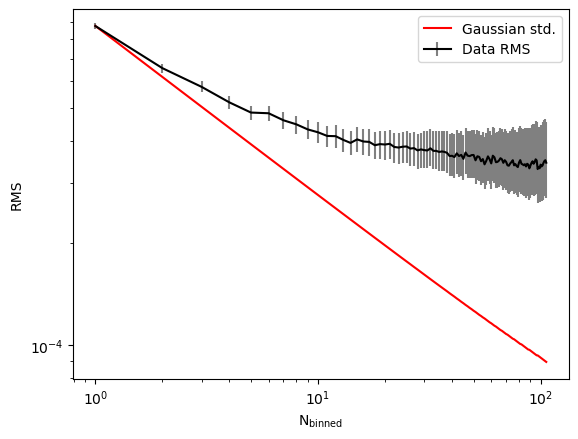

In [254]:
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
astro = transit_model(time, t_s, fp)
detec = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
residuals = (aplev/detec) - astro
plot_rednoise(residuals, 10)
# duration of transit is 1.13 hours

1062


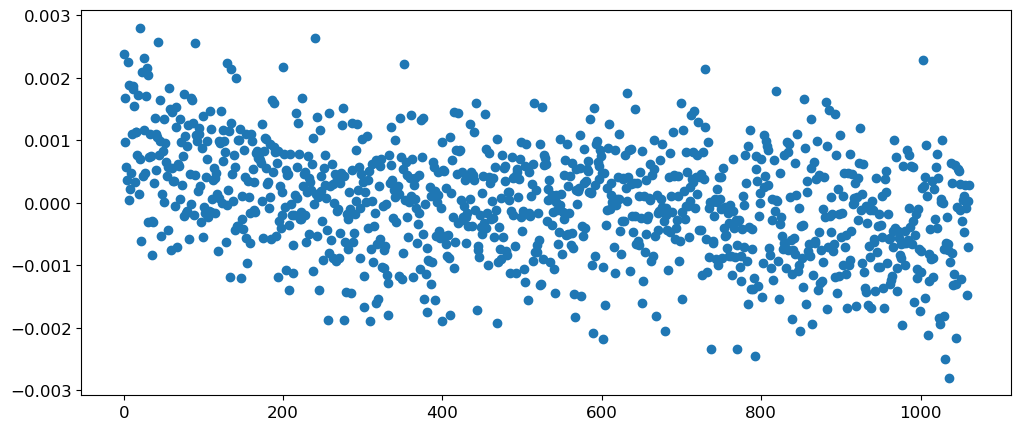

In [261]:
print(len(residuals))
plt.figure(figsize=(12,5))
plt.plot(residuals, 'o')

In [281]:
aperr     = aperr/np.mean(aplev)
aplev     = aplev/np.mean(aplev)

t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
astro = transit_model(time, t_s, fp)
detec = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
residuals = (aplev/detec) - astro

print(np.std(residuals[350:])/np.mean(aperr[350:]))

1.241758622774539


In [223]:
# BIC calculations
def BIC(n_dat, n_par, lnL):
    return n_par*np.log(n_dat) - 2*lnL  

# lnL is the likelihood value of best fit model, formula that depends on chi2, recheck

bic = BIC(len(time), len(p0_mcmc), lnprobchain.max())
print(bic)

-13836.32663183321


In [326]:
# chi squared
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc

def chi_squared(time, flux, centroid_x, centroid_y, p0_mcmc):
    t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
    astro = transit_model(time, t_s, fp)
    model = signal(time, centroid_x, centroid_y, t_s, fp, c1, c2, c3, c4, c5, c6)
    sigma2 = sigF**2
    return np.sum((flux - model) ** 2 / sigma2)

chi = chi_squared(time, aplev, centroid_x, centroid_y, p0_mcmc)
print(chi)

# chi squared per data point
## is it signal or astro model that i use???
# if flux corrigé -> only astro model

1082.121601307846


In [141]:
# temperature calculation
t_star = 3096 #3216 
A_b = 0.0
a = 26.57 # ratio a/t_s
R_s = 0.2159
f = 2/3 # heat redistribution #2/3 # no heat redristribution
fp = 0.0005661522322664744 #p0[1]

#fp = p0[1]
t_eq_c = t_star * np.sqrt(1/a) * (1/4*(1 - A_b)) ** 0.25 
t_eq_n = t_star * np.sqrt(1/a) * (2/3*(1 - A_b)) ** 0.25 
t_eq_weird = t_star * np.sqrt(1/a) * (1/4*(1 - 0.8)) ** 0.25 
print(t_eq_c, t_eq_n, t_eq_weird)
# very similar to value reported by cadieux 2024 according to nasa exoplanet archive

424.7077411728199 542.728165084768 284.01918435775883


In [118]:
# plancks law
planck_cts = 6.62607015e-34

c = 299792458
k = 1.380649e-23
t_star = 3096
#l =  # lambda

def t_brightness(fp, l):
    h = 6.62607015e-34
    c = 299792458
    k = 1.380649e-23
    t_star = 3096
    t_depth = 2900
    return ((h * c) / (k * l)) * (np.log(1 + ((np.exp((h * c)/(l * k * t_star)) -1 )/(fp/t_depth)))) ** -1

In [135]:
fp = 566.1522322664744 #p0[1]
l = 15e-6
t_bright = t_brightness(fp, l)
print(t_bright)

912.7117904561848


In [16]:
fp =[0.0005661522322664744,  5.785961593619154e-05 , 5.756880696813492e-05] 

print(fp[0]*1e6, fp[1]*1e6, fp[2]*1e6)


566.1522322664744 57.85961593619154 57.56880696813492


In [159]:
wav = np.arange(0.01, 50) * u.um

bb_s = BlackBody(temperature=t_star*u.K)
bb_c = BlackBody(temperature=t_eq_c*u.K)
bb_n = BlackBody(temperature=t_eq_n*u.K)
bb_bright = BlackBody(temperature=t_bright*u.K)
bb_weird = BlackBody(temperature=t_eq_weird*u.K)
flux_s = bb_s(wav)
flux_c = bb_c(wav)
flux_n = bb_n(wav)
flux_weird = bb_weird(wav)
flux_bright = bb_bright(wav)

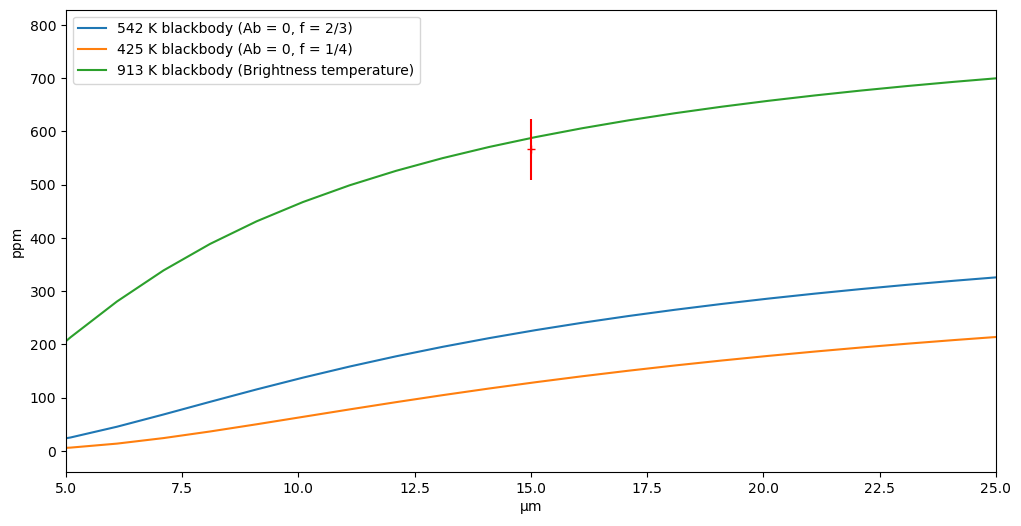

In [148]:
# blackbody ratio graph


with quantity_support():
    plt.figure(figsize=(12, 6))
    #plt.plot()
    plt.plot(wav, 0.05486**2*(flux_n / flux_s)*1e6, label = '542 K blackbody (Ab = 0, f = 2/3)')    
    plt.plot(wav, 0.05486**2*(flux_c / flux_s)*1e6, label = '425 K blackbody (Ab = 0, f = 1/4)') 
    plt.plot(wav, 0.05486**2*(flux_bright / flux_s)*1e6, label = '%3.f K blackbody (Brightness temperature)' %t_bright)
    #plt.plot(wav, 0.05486**2*(flux_weird / flux_s)*1e6, label = '%3.f K blackbody (Ab = 0.8, f = 1/4)' % t_eq_weird)

    #plt.plot(15, 0.0005661522322664744, '+', markersize=10, color='red')
    #plt.errorbar(15, 0.0005661522322664744, yerr=5.785961593619154e-05, fmt='o', color='red')

    plt.errorbar(15, 0.0005661522322664744*1e6, yerr=5.785961593619154e-05*1e6, fmt='+', color='red')
    plt.ylabel('ppm')
    plt.legend()
    #plt.ylim(0, 5000)
    plt.xlim(5, 25)
    plt.show()


    # area p * fp / area s * fs

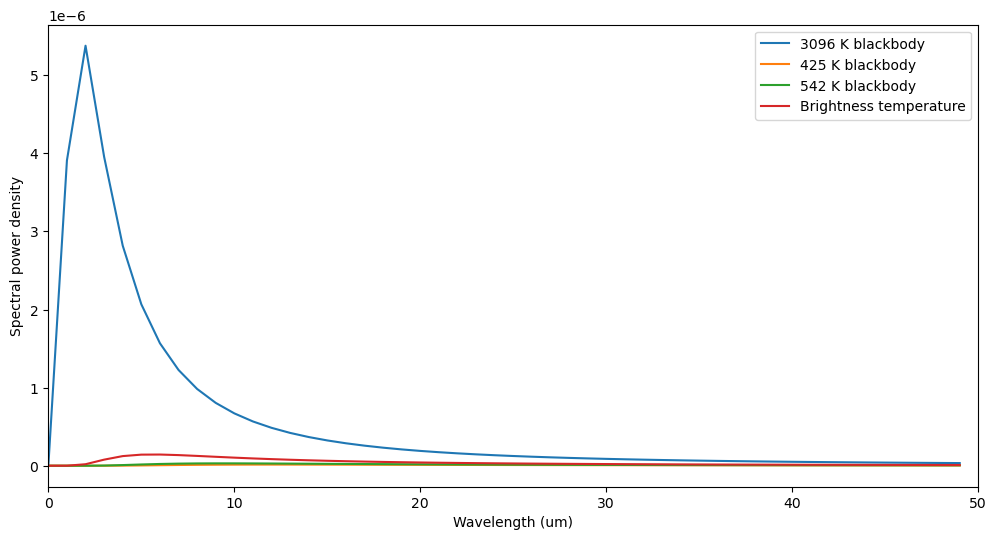

In [160]:
plt.figure(figsize=(12, 6))
plt.plot(wav, flux_s, label='3096 K blackbody')
plt.plot(wav, flux_c, label='425 K blackbody')
plt.plot(wav, flux_n, label='542 K blackbody')
plt.plot(wav, flux_bright, label='Brightness temperature')
plt.legend()
plt.ylabel('Spectral power density')
plt.xlabel('Wavelength (um)')
plt.xlim(0, 50)
plt.show()

In [60]:
print(flux_c / flux_s)

[1.14080250e-127 2.06096096e-126 3.51791035e-125 ... 7.09998056e-002
 7.10018800e-002 7.10039543e-002]


In [ ]:
# header = 'HEADER for LHS1140: time, time-t0, corrected flux, uncertainty'
# time4 = time-58226.27035938386
# flux4 = flux/detect_bfit
# err4 = 0.0006149751927953781
# data = [header, time, timezero, flux4, err4]
# pathdata = 'LHS1140-4_cleaned.pkl'
# with open(pathdata, 'wb') as outfile:
#     pickle.dump(data, outfile, pickle.HIGHEST_PROTOCOL)


In [ ]:
# plt.errorbar(time1, flux1, err1, alpha=0.3, label='visit1-poly')
# plt.errorbar(time2, flux2, err2, alpha=0.3, label='visit2')
# plt.errorbar(time3, flux3, err3, alpha=0.3, label='visit3')
# plt.errorbar(time4, flux4, err4, alpha=0.3, label='visit4')
# plt.legend()
# plt.savefig('LHS1140_1_3_corrected.pdf')

In [ ]:
# plt.plot(time, flux4, '.')